# Classifier Comparison

In this example we show how all **Concrete-ML** classifiers can be used in a manner that is very 
similar to scikit-learn classifiers. FHE classifiers have an API that builds upon the scikit-learn 
API, adding two new elements:

* compiling the model to FHE
* predicting in FHE

The FHE classifiers, which quantize the inputs and model parameters, can be tested in a simulated
FHE environment called the "Virtual Library". This type of execution is much faster than running in
FHE, but it does not operate over encrypted data. However, the Virtual Library is very useful to 
design and train FHE compatible classifiers, as it allows the user to investigate whether the FHE
constraints are met at design time.

### FHE runtime considerations and simulation

In this demo the test data is classified in FHE and the decision function values for the domain
grid are computed using simulation, using the Virtual Library. Thus:

* the accuracy reported is computed in FHE
* the red/blue decision function contours are computed with simulation

However, since the runtimes in FHE are high (it can take up to an hour to run test set 
classification in FHE), you have the option to run everything in simulation by 
setting ALWAYS_USE_VL=True.

In [14]:
# Source:
#   https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified to integrate Concrete-ML functions by Zama
# License: BSD 3 clause

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import time
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from concrete.numpy.compilation.configuration import Configuration
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

from concrete.ml.sklearn import (
    DecisionTreeClassifier,
    LinearSVC,
    LogisticRegression,
    NeuralNetClassifier,
    RandomForestClassifier,
    XGBClassifier,
)

%matplotlib inline


# The Virtual Library allows to simulate FHE executions without paying the cost of FHE
# computations. However, data is not encrypted when using the Virtual Library, the model executes
# an integer model on data in the clear.
ALWAYS_USE_VL = False

# Initialize the configuration used for Virtual Library tests only.
COMPIL_CONFIG_VL = Configuration(
    dump_artifacts_on_unexpected_failures=False,
    enable_unsafe_features=True,
)

In [15]:
from IPython.display import clear_output


# pylint: disable=too-many-locals,too-many-statements,too-many-branches
def make_classifier_comparison(title, classifiers):

    h = 0.04  # Step size in the mesh

    X, y = make_classification(
        n_samples=200,
        n_features=2,
        n_redundant=0,
        n_informative=2,
        random_state=1,
        n_clusters_per_class=1,
    )
    rng = np.random.RandomState(2)
    X += 2 * rng.uniform(size=X.shape)
    linearly_separable = (X, y)

    datasets = [
        make_moons(n_samples=200, noise=0.3, random_state=0),
        make_circles(n_samples=200, noise=0.2, factor=0.5, random_state=1),
        linearly_separable,
    ]

    font_size_text = 20

    fig, axs = plt.subplots(len(datasets), 2 * len(classifiers) + 1, figsize=(32, 16))
    fig.suptitle(title, fontsize=20)
    fig.patch.set_facecolor("white")

    # Iterate over datasets
    for i, dataset in enumerate(datasets):
        # Preprocess dataset
        X, y = dataset
        X = X.astype(np.float32)
        X = StandardScaler().fit_transform(X)

        # Split the data into training and test sets
        # Use 15 percent (30 points for a dataset of 200 points) for prediction
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        cm = plt.cm.RdBu
        cm_bright = ListedColormap(["#FF0000", "#0000FF"])
        ax = axs[i, 0]
        if i == 0:
            ax.set_title("Input data", fontsize=font_size_text)

        # Plot the training points
        ax.scatter(
            X_train[:, 0],
            X_train[:, 1],
            c=y_train,
            cmap=cm_bright,
            edgecolors="k",
            label="Train data",
        )

        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            marker="D",
            c=y_test,
            cmap=cm_bright,
            alpha=0.6,
            edgecolors="k",
            label="Test data",
        )
        ax.legend()

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())

        # Iterate over the given classifiers
        for j, (classifier, model_name) in enumerate(classifiers):
            # Instantiate the model
            model = classifier()

            # Train the model and retrieve both the Concrete-ML model and its equivalent one from
            # scikit-learn
            # If the model is a NeuralNetClassifier, instantiate a scikit-learn MLPClassifier
            # separately in order to be able to be able to compare the results with a float model
            # that doesn't use QAT
            if model.__class__ == NeuralNetClassifier:
                sklearn_model = MLPClassifier(alpha=1, max_iter=1000, hidden_layer_sizes=(20,))
                sklearn_model.fit(X_train, y_train)
                concrete_model = model.fit(X_train, y_train)
            else:
                concrete_model, sklearn_model = model.fit_benchmark(X_train, y_train)

            # Compute the predictions in clear using the scikit-learn model
            sklearn_y_pred = sklearn_model.predict(X_test)

            # Compile the Concrete-ML model
            circuit = concrete_model.compile(
                X_train,
                use_virtual_lib=ALWAYS_USE_VL,
                configuration=COMPIL_CONFIG_VL if ALWAYS_USE_VL else None,
            )

            # If the prediction are done in FHE, generate the key
            if not ALWAYS_USE_VL:

                print(
                    "Generating a key for a "
                    f"{circuit.graph.maximum_integer_bit_width()}-bit circuit"
                )

                time_begin = time.time()
                circuit.client.keygen(force=False)
                print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

            # Compute the predictions in FHE using the Concrete-ML model
            time_begin = time.time()
            concrete_y_pred = concrete_model.predict(X_test, execute_in_fhe=True)
            print(
                f"Execution time: {(time.time() - time_begin) / len(X_test):.2f} "
                "seconds per sample"
            )

            # Measure the accuracy scores
            sklearn_score = accuracy_score(sklearn_y_pred, y_test)
            concrete_score = accuracy_score(concrete_y_pred, y_test)

            is_a_tree_based_model = concrete_model.__class__ in [
                DecisionTreeClassifier,
                DecisionTreeClassifier,
            ]

            # If the model is not a tree-based model, retrieve the maximum integer bitwidth
            # reached within its circuit.
            bitwidth = None
            if not is_a_tree_based_model:
                bitwidth = circuit.graph.maximum_integer_bit_width()

            # Plot the decision boundaries.
            # For that, a color is assigned to each point in the mesh, which is obtained as a
            # cartesian product of [x_min, x_max] with [y_min, y_max].
            if hasattr(sklearn_model, "decision_function"):
                # Note that although we pass execute_in_fhe=True, execution is only simulated
                # since we compiled with use_virtual_lib=True
                sklearn_Z = sklearn_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
                concrete_Z = concrete_model.decision_function(
                    np.c_[xx.ravel(), yy.ravel()],
                    execute_in_fhe=True,
                )
            else:
                # Note that although we pass execute_in_fhe=True, execution is only simulated
                # since we compiled with use_virtual_lib=True
                sklearn_Z = sklearn_model.predict_proba(
                    np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
                )[:, 1]
                concrete_Z = concrete_model.predict_proba(
                    np.c_[xx.ravel(), yy.ravel()],
                    execute_in_fhe=True,
                )[:, 1]

            for k, (framework, score, Z) in enumerate(
                zip(
                    ["scikit-learn", "Concrete-ML"],
                    [sklearn_score, concrete_score],
                    [sklearn_Z, concrete_Z],
                )
            ):
                ax = axs[i, 2 * j + k + 1]

                # Put the result into a color plot
                Z = Z.reshape(xx.shape)
                ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

                # Plot the training points
                ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

                # Plot the testing points
                ax.scatter(
                    X_test[:, 0],
                    X_test[:, 1],
                    c=y_test,
                    marker="D",
                    cmap=cm_bright,
                    edgecolors="k",
                    alpha=0.6,
                )

                ax.contour(
                    xx,
                    yy,
                    Z,
                    levels=[0.5],
                    linewidths=2,
                )

                ax.set_xlim(xx.min(), xx.max())
                ax.set_ylim(yy.min(), yy.max())
                ax.set_xticks(())
                ax.set_yticks(())

                if i == 0:
                    ax.set_title(model_name + f" ({framework})", fontsize=font_size_text)

                ax.text(
                    xx.max() - 0.3,
                    yy.min() + 0.3,
                    f"{score*100:0.1f}%",
                    size=font_size_text,
                    horizontalalignment="right",
                )

                if bitwidth and framework == "Concrete-ML":
                    ax.text(
                        xx.max() - 0.3,
                        yy.min() + 1.0,
                        f"bitwidth={bitwidth}",
                        size=font_size_text,
                        horizontalalignment="right",
                    )

    clear_output(wait=True)

    plt.tight_layout()
    plt.show()

### Neural-net-based classifiers

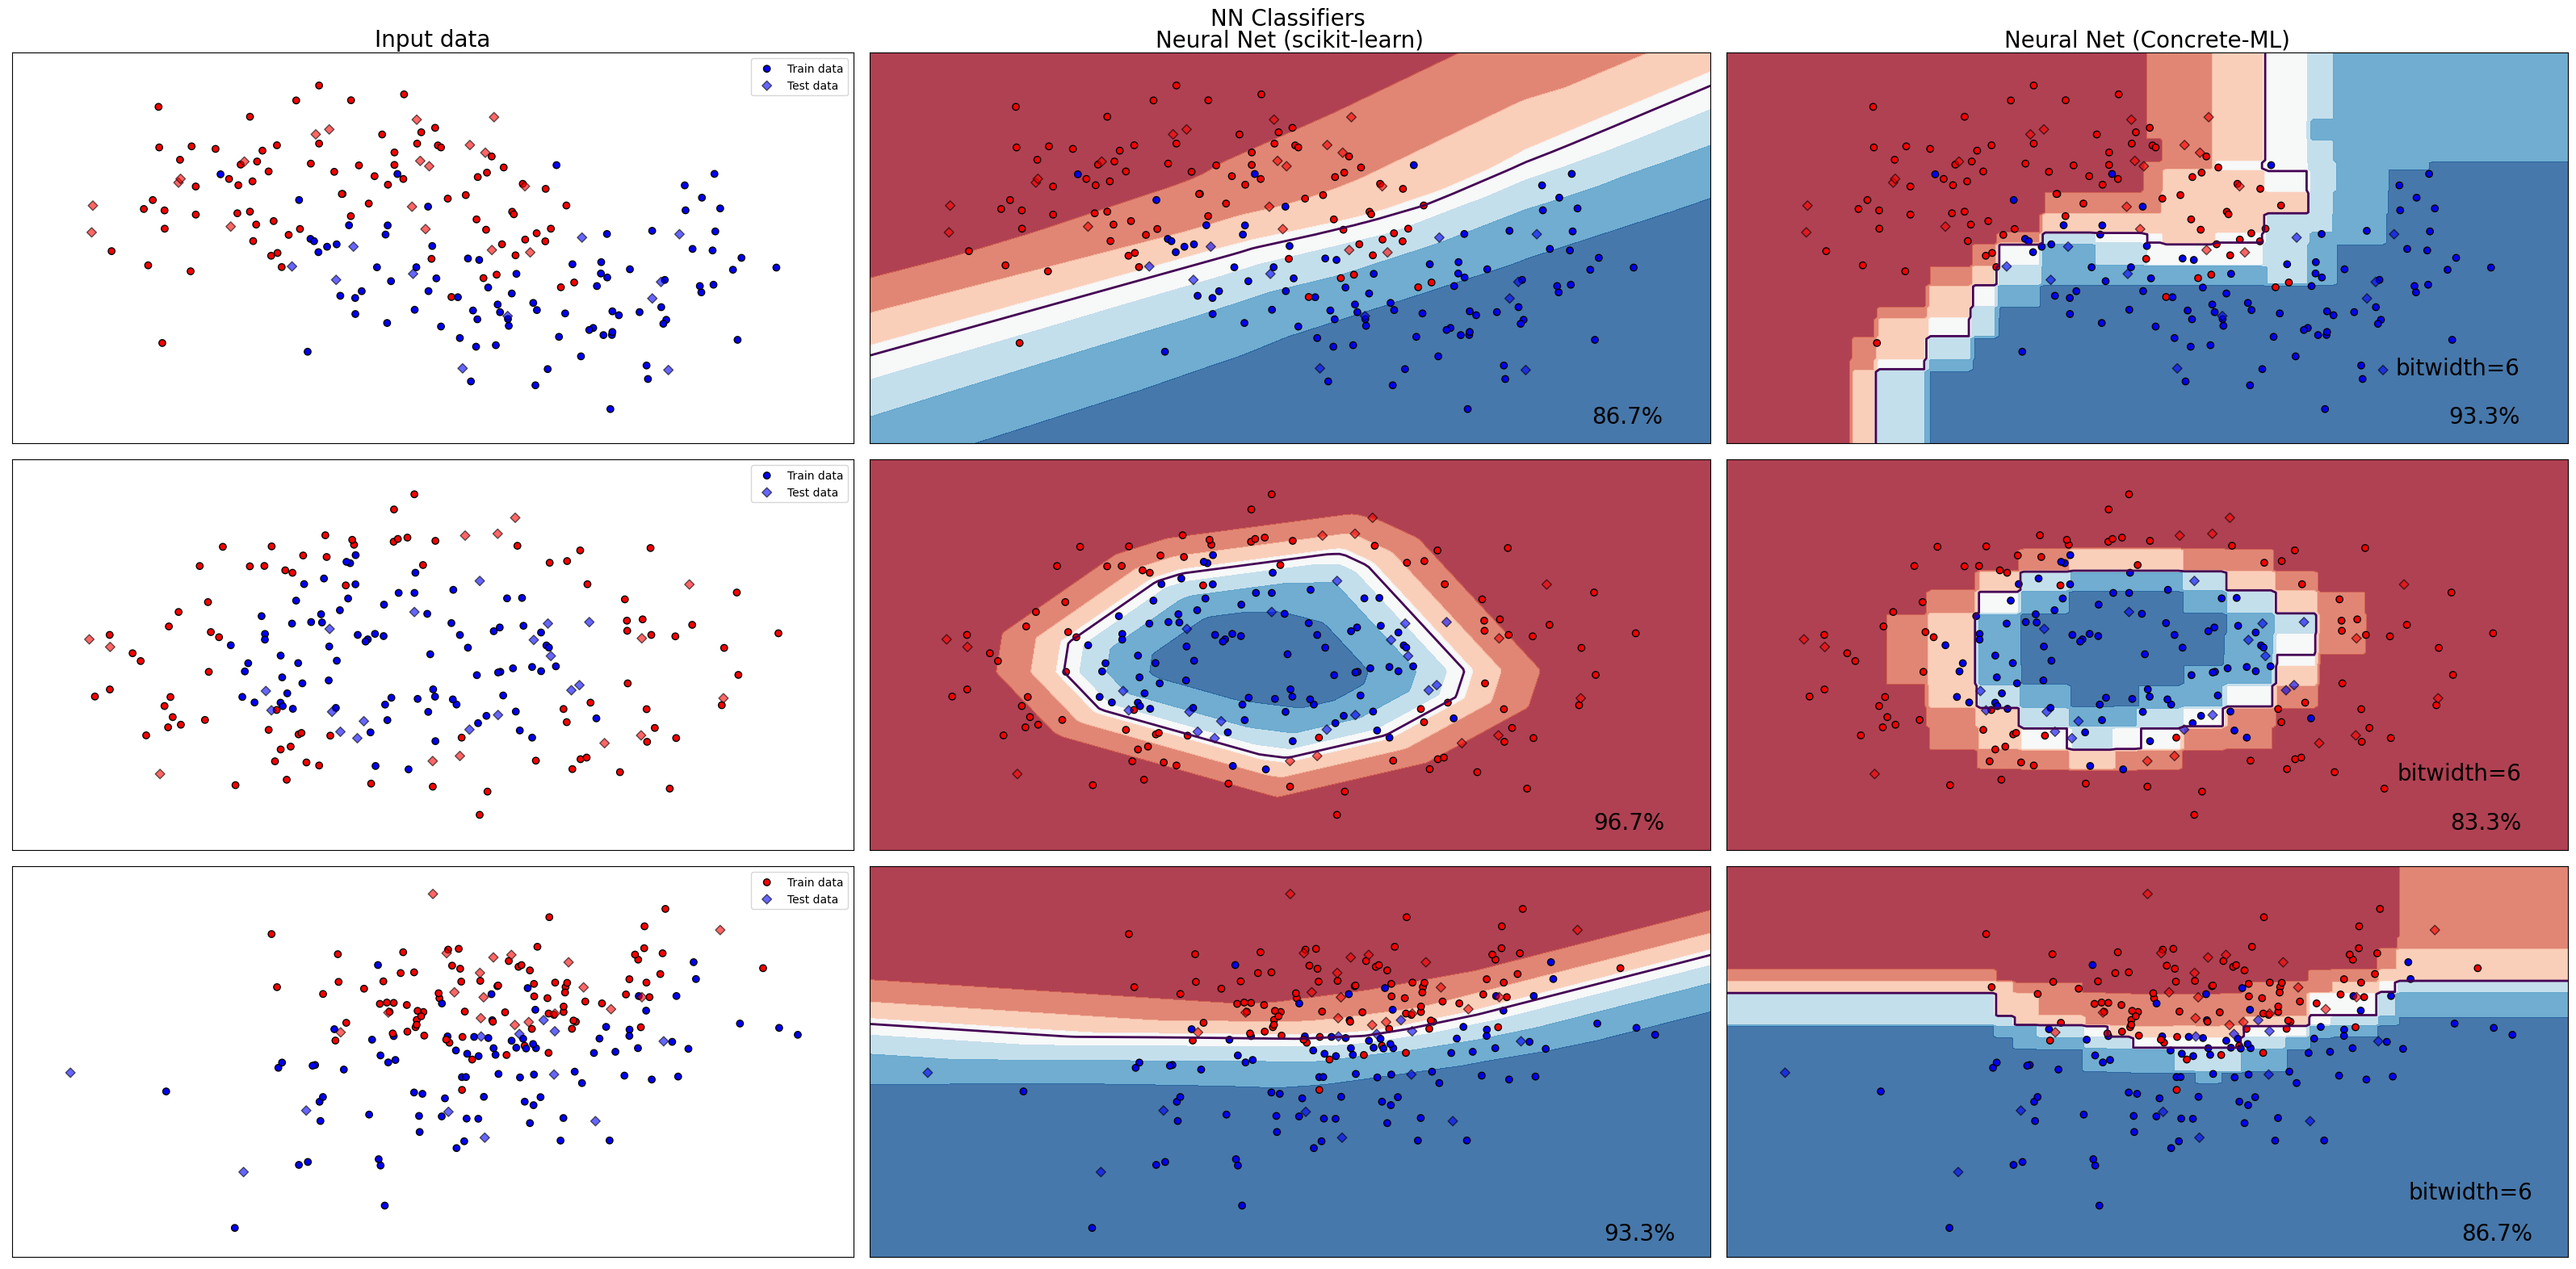

In [16]:
params_neural_net = {
    "module__n_outputs": 2,
    "module__input_dim": 2,
    "module__n_w_bits": 2,
    "module__n_a_bits": 4,
    "module__n_accum_bits": 32,
    "module__n_hidden_neurons_multiplier": 10,
    "module__n_layers": 2,  # 1 hidden layer
    "module__activation_function": torch.nn.ReLU,
    "max_epochs": 400,
    "verbose": 0,
    "lr": 0.001,
}

neural_network_classifiers = [
    (
        partial(NeuralNetClassifier, batch_size=32, **params_neural_net),
        "Neural Net",
    ),
]

make_classifier_comparison("NN Classifiers", neural_network_classifiers)

### Linear classifiers

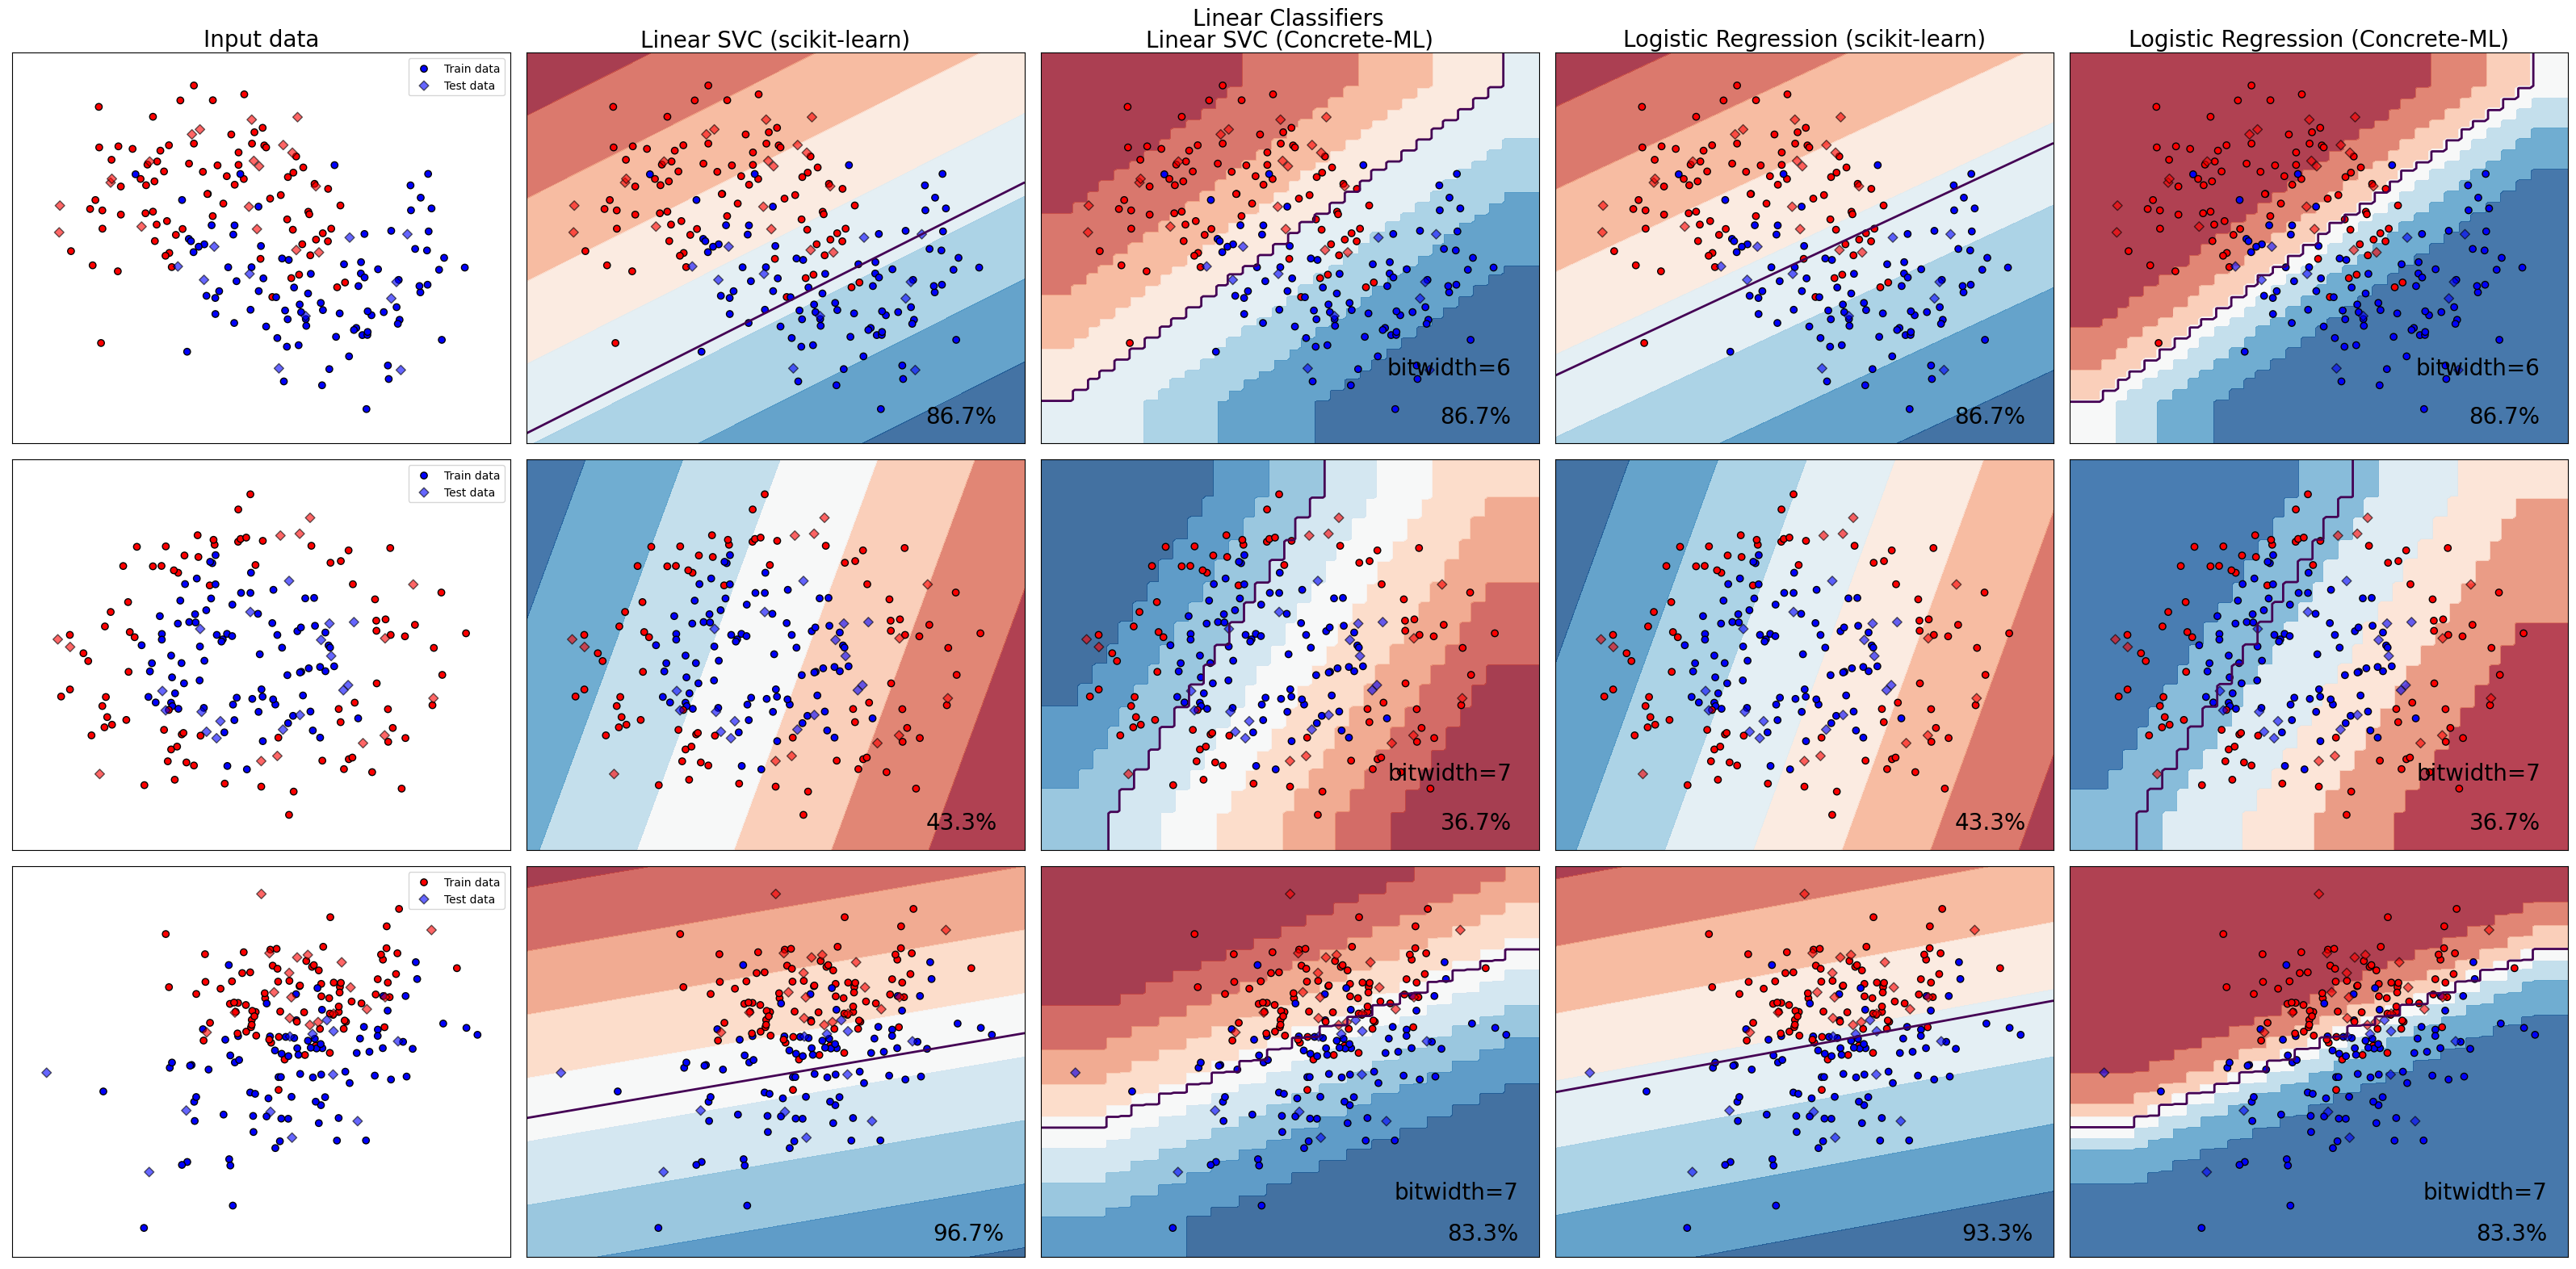

In [58]:
linear_classifiers = [
    (partial(LinearSVC, n_bits={"op_inputs": 5, "op_weights": 2}, C=0.025), "Linear SVC"),
    (partial(LogisticRegression, n_bits={"op_inputs": 5, "op_weights": 2}), "Logistic Regression"),
]

make_classifier_comparison("Linear Classifiers", linear_classifiers)

### Tree and tree ensemble classifiers

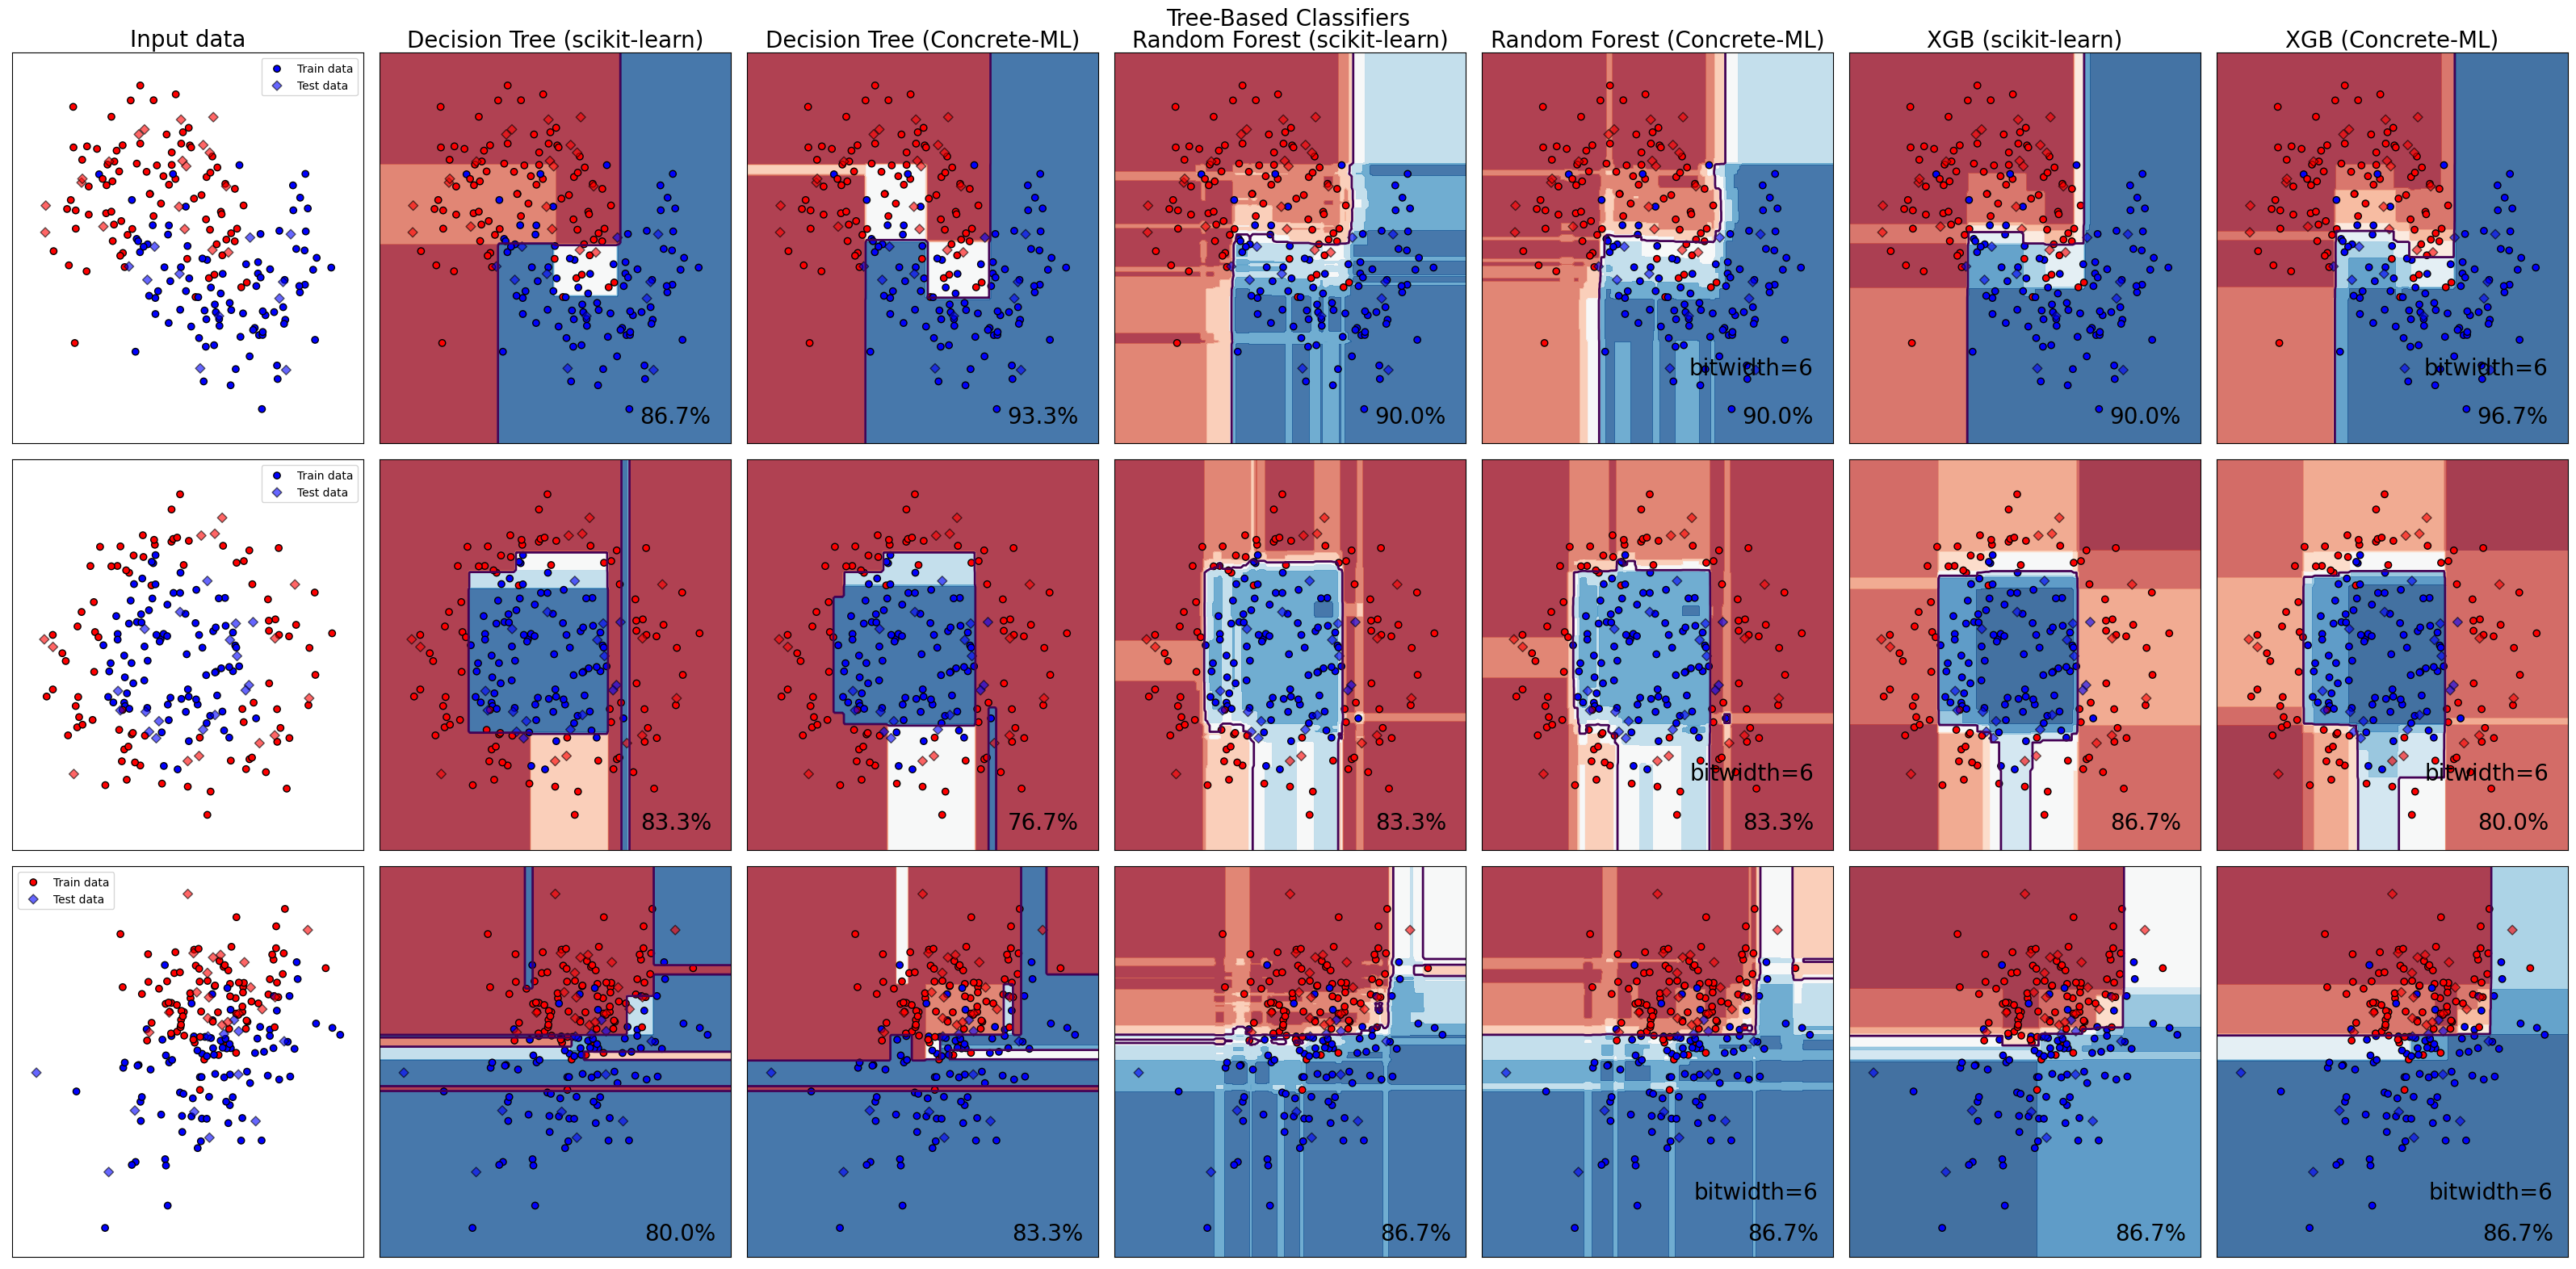

In [57]:
tree_classifiers = [
    (partial(DecisionTreeClassifier, max_depth=5), "Decision Tree"),
    (RandomForestClassifier, "Random Forest"),
    (partial(XGBClassifier, n_jobs=1), "XGB"),
]

make_classifier_comparison("Tree-Based Classifiers", tree_classifiers)

## Conclusion

In this example we showed the results of three types of classifiers: 

* linear (Support Vector Machine, Logistic Regression)
* neural-networks (multi-layer non-linear models)
* tree-based (Decision Tree, Random Forest, XGBoost)

The accuracy of the **Concrete** classifiers is measured on encrypted data. These classifiers 
work with parameters and inputs that are heavily quantized and, thus, show accuracy loss:

* linear models: for this simple 2D case, linear models have good performance in FHE, similar to 
the performance of their fp32 counterparts
* neural networks: as seen above, Neural Networks have good performance in FHE despite being 
subjected to heavy quantization thanks to Quantization Aware Training (QAT) techniques
* tree-based classifiers: these classifiers achieve good accuracy both in fp32 and in quantized 
mode in FHE on encrypted data. Due to the particular computations in tree-based models, performance 
in FHE is maintained at the fp32 levels even on datasets which have a much higher number of 
dimensions

## Future work

In future releases of **Concrete-ML** we will improve the performance of linear classifiers on data
by considering more dimensions.